In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'
from ipywidgets import interact
import scipy.sparse as sparse
from scipy.sparse import linalg as spla
from scipy import interpolate as interp

Populating the interactive namespace from numpy and matplotlib


# Crank-Nicolson Method
## The model problem
$$ \frac{\partial u}{\partial t} = \kappa\frac{\partial^2 u}{\partial x^2}, \quad x \in [0, 1], $$
with Dirichlet boundary conditions
$$ u(0, t) = g_0(t), \quad u(1, t) = g_1(t), \quad t > 0, $$
and the initial condition
$$ u(x, 0) = \eta(x), \quad x \in [0, 1] .$$
Discretize space on $[0, 1]$ into $m+1$ intervals with spacing $h = 1/(m+1)$. Discretize time with $t_n = kn$, $n=0, 1, \ldots$, where $k>0$ is the time step parameter.

In [2]:
kappa = .02 # diffusion coefficient parameter (units of length^2/time)

## time discretization
N_time_steps = 100
T = 3. # max time
k = T/N_time_steps # time step
t = linspace(0, T, N_time_steps+1)

## space discretization
m = 50
h = 1/(m+1)
x = linspace(0, 1, m+2)

## Exact solution
## For Gaussian initial conditions u(x,0) = exp(-beta * (x-0.4)^2)
def uexact(x, t):
    beta = 150.
    return exp(-(x - 0.4)**2/(4*kappa*t + 1/beta))/sqrt(4*beta*kappa*t+1)
# use broadcasting for vectorized evaluation (see notebook in our repository for tutorial) 
# this also works for 2D or 3D spatial grids
# I like to have time as first index and space as second index
utrue = uexact(x[None, :], t[:, None])

## initial condition
u0 = utrue[0, :]

## boundary conditions
g0 = utrue[:, 0]
g1 = utrue[:, -1]

## initialize solution array
u = utrue.copy()

## matrices
mu = kappa*k/h**2/2. # a convenient parameter defininition (non dimensional)
e = ones(m)
A1 = sparse.spdiags([e, -2*e, e], [-1, 0, 1], m, m)
I = sparse.eye(m)
M_LHS = I - mu*A1
M_RHS = I + mu*A1

## The following is roughly equivalent to Thomas' method
## Use LU decomposition function to return a 'solver' object with a `solve` method
# The solver uses the L and U matrices and so can solve in O(m) operations 
# (O(m) for this tridiagonal matrix, it is O(m^2) in general)
M_LHS_solver = spla.splu(M_LHS)

for n in arange(N_time_steps):
    # right hand side of linear system
    rhs = M_RHS@u[n, 1:-1]
    # correct for boundary conditions
    rhs[0] += mu*(g0[n] + g0[n+1])
    rhs[-1] += mu*(g1[n] + g1[n+1])
    # solve linear system using LU solver object
    u[n+1, 1:-1] = M_LHS_solver.solve(rhs) ## solve linear system for U^{n+1}

/usr/local/lib/python3.9/dist-packages/scipy/sparse/linalg/_dsolve/linsolve.py:394: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)


In [3]:
## visualize solution
@interact(n=(0, N_time_steps, 1))
def plotfn(n=0):
    fig = figure(1, [14, 4])
    fig.add_subplot(121)
    plot(x, utrue[n], 'k')
    plot(x, u[n], 'o')
    ylim(0, 1)
    xlabel(r'$x$', fontsize=24)
    ylabel(r'$u$', fontsize=24)
    
    fig.add_subplot(122)
    plot(x, u[n] - utrue[n], 'k')
    xlabel(r'$x$', fontsize=24)
    ylabel(r'error', fontsize=24);

interactive(children=(IntSlider(value=0, description='n'), Output()), _dom_classes=('widget-interact',))

In [4]:
## Let's get fancy!
from io import BytesIO
import ipywidgets as widgets
import traitlets

def make_time_player(frameRate=1/40):
    play = widgets.Play(
        interval=1/frameRate,
        value=0, 
        min=0, 
        max=N_time_steps, 
        step=1,
        description="Press play",
        disabled=False)
    slider = widgets.IntSlider(
        min=0, 
        max=N_time_steps,
        step=1,
        description='n')
    traitlets.link((play, 'value'), (slider, 'value'))
    return play, widgets.HBox([play, slider])

## this only creates the time buttons and slider at the bottom
play, time_widget = make_time_player(frameRate=1/100)

def vplotfn(change):
    n = int(change['new'])
    
    fig = figure(1, [14, 4])
    fig.add_subplot(121)
    plot(x, utrue[n], 'k')
    plot(x, u[n], 'o')
    ylim(0, 1)
    xlabel(r'$x$', fontsize=24)
    ylabel(r'$u$', fontsize=24)
    
    fig.add_subplot(122)
    plot(x, u[n] - utrue[n], 'k')
    xlabel(r'$x$', fontsize=24)
    ylabel(r'error', fontsize=24)
    
    f = BytesIO()
    savefig(f, format='png', dpi=300)
    #display(IPython.display.Image(f.getvalue(), retina=True, embed=True))
    #fig.clf();
    close(fig)
    return f.getvalue()

## this widget displays an image
Wimg = widgets.Image(
    value=vplotfn({'new': 0}),
    format='png',
    width=1008,
    height=288,
)


def call_back(change, equalize=True, tracking=True):
    Wimg.value = vplotfn(change)
    return None
## we want to update the image that is being displayed by the image widget whenver the time slider changes value
## this is done using a 'callback' function that gets called whenever the time slider 'value' changes
play.observe(call_back, 'value')
## this widget combines the previous two into a single widget
widgets.VBox([Wimg, time_widget])

# Optimizing the spectrum of $G_{\omega}$
For underrelaxed Jacobi on the 1D model Poisson problem, $x \in [0, 1]$, we want to pick $\omega$ to minimize the higher frequency eigenvalues. That is,
$$ \mu = \min_{\omega \in (0, 1]} \max_{m/2 \leq j \leq m} \vert \gamma_j \vert $$


In [5]:
m = 50
x = linspace(0, 1, m+1)

@interact(w=(0, 1, 0.05))
def plotfn(w=1.):
    gamma = 1 - w + w*cos(pi*x)
    abs_gamma = absolute(gamma)
    gmax = abs_gamma[m//2:].max()
    plot(x, abs_gamma, '-o')
    plot(x, 0*x + gmax, '--k')
    plot(0*x + 0.5, x*1.1, 'k')
    
    xlim(0, 1)
    ylim(0, 1.1)
    xlabel(r'$jh$', fontsize=24)
    ylabel(r'$\vert\gamma_j \vert$', fontsize=24);

interactive(children=(FloatSlider(value=1.0, description='w', max=1.0, step=0.05), Output()), _dom_classes=('w…

# 1D multigrid model problem

In [6]:
rho = 20.
def rhs(x):
    phi = rho*pi*x**3
    phix = rho*pi*3*x**2
    phixx = (rho*pi*6*x)
    return -20 + 0.5*phixx*cos(phi) - 0.5*phix**2*sin(phi)

def Jacobi(u0, F, kmax, w, m):
    h = 1/(m+1)
    e = ones(m)
    Abar = sparse.spdiags([e/2., -e, e/2.], [-1, 0, 1], m, m)
    I = sparse.eye(m)
    Gw = I + w*Abar
    u = u0.copy()
    for k in arange(kmax):
        u = Gw@u - w*h**2/2*F
    r = F - 2./h**2*Abar@u
    return u, r

# Eigenvector expansion of the initial error

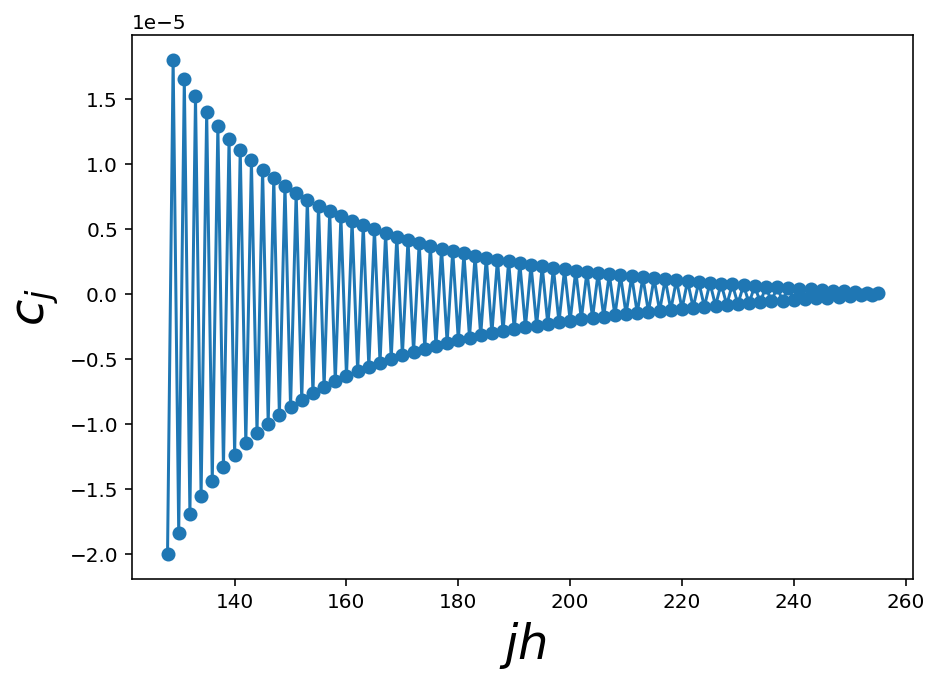

In [7]:
m = 255
h = 1/(m+1)
x = linspace(0, 1, m+2)

x = linspace(0, 1, m+2)
F = rhs(x[1:-1])
F[0] -= 1./h**2
F[-1] -= 3./h**2

u0 = linspace(1, 3, m+2)[1:-1]
u = zeros(m+2)
u[0] = 1
u[-1] = 3

uexact = 1 + 12*x - 10*x**2 + 0.5*sin(rho*pi*x**3)

# u[1:-1] = Jacobi(u0, 0, 1.)
e0 = u0 - uexact[1:-1]
ij = arange(1, m+1)
_I, _J = meshgrid(ij, ij, indexing='ij')
V = sin(_J*_I*pi*h)
c = solve(V, e0)

figure(1, [7, 5])
# plot(ij*h, c, '-o')
plot(ij[m//2:], c[m//2:], '-o')
xlabel(r'$jh$', fontsize=24)
ylabel(r'$c_j$', fontsize=24);

# Solving the model problem with Jacobi iteration 

In [8]:
w = 1.
m = 255
h = 1/(m+1)
x = linspace(0, 1, m+2)

x = linspace(0, 1, m+2)
F = rhs(x[1:-1])
F[0] -= 1./h**2
F[-1] -= 3./h**2

u0 = linspace(1, 3, m+2)[1:-1]
u = zeros(m+2)
u[0] = 1
u[-1] = 3

uexact = 1 + 12*x - 10*x**2 + 0.5*sin(rho*pi*x**3)

@interact(k=(0, 300, 10))
def plotfn2(k=0):
    u[1:-1], _ = Jacobi(u0, F, k, w, m)
    fig = figure(1, [14, 5])
    fig.add_subplot(121)
    plot(x, u, '-x')
    plot(x, uexact, 'k')
    xlabel(r'$x$', fontsize=24)
    ylabel(r'$u$', fontsize=24)
    
    fig.add_subplot(122)
    plot(x, u - uexact, 'k')
    xlabel(r'$x$', fontsize=24)
    ylabel(r'$e_k$', fontsize=24)
    ylim(-3, 0.1)
    

interactive(children=(IntSlider(value=0, description='k', max=300, step=10), Output()), _dom_classes=('widget-…

# Two grid solution using Jacobi

In [9]:
w = 2/3
# nu = 20
m0 = 250
h0 = 1/(m0 + 1)
xb = linspace(0, 1, m0+2)
x = xb[1:-1]

F = rhs(x)
F[0] -= 1./h0**2
F[-1] -= 3./h0**2

u0 = linspace(1, 3, m0+2)[1:-1]
u = zeros(m0+2)
u[0] = 1
u[-1] = 3

uexact = 1 + 12*xb - 10*xb**2 + 0.5*sin(rho*pi*xb**3)



@interact(nu=(0, 300, 10))
def plotfn3(nu=10):
    ## nu iterations on the fine grid
    u_nu, r_nu = Jacobi(u0, F, nu, w, m0)

    d = 2
    m_coarse = m0//d
    ## downsampling to coarse grid
    x_coarse = linspace(0, 1, m_coarse+2)[1:-1]
    r_nu_of_x = interp.interp1d(xb, r_[0, r_nu, 0], kind='linear')
    r_coarse = r_nu_of_x(x_coarse)
    e0_coarse = zeros(m_coarse)

    ## solve error on coarse grid
    e_nu_coarse, r_nu_coarse = Jacobi(e0_coarse, -r_coarse, nu, w, m_coarse)

    ## interpolate error to fine grid
    e_of_x = interp.interp1d(r_[0, x_coarse, 1], r_[0, e_nu_coarse, 0], kind='linear')
    e_nu = e_of_x(x)

    ## subtract error from fine grid solution
    u[1:-1] = u_nu - e_nu
    
    fig = figure(1, [14, 5])
    fig.add_subplot(121)
    plot(xb, uexact, 'k')
    plot(x, u_nu)
    plot(xb, u)
    xlabel(r'$x$', fontsize=24)
    ylabel(r'$u$', fontsize=24)
    
    fig.add_subplot(122)
    #plot(x, e_nu, '-ob')
    plot(x, u_nu - uexact[1:-1])
    plot(xb, u - uexact)
    xlabel(r'$x$', fontsize=24)
    ylabel(r'$e_k$', fontsize=24)
    #ylim(-3, 0.1)

interactive(children=(IntSlider(value=10, description='nu', max=300, step=10), Output()), _dom_classes=('widge…

# $N$ grid solution using Jacobi

In [10]:
w = 2/3
# nu = 20
m0 = 256
h0 = 1/(m0 + 1)
xb = linspace(0, 1, m0+2)
x = xb[1:-1]

F = rhs(x)
F[0] -= 1./h0**2
F[-1] -= 3./h0**2

u0 = linspace(1, 3, m0+2)[1:-1]
u = zeros(m0+2)
u[0] = 1
u[-1] = 3

uexact = 1 + 12*xb - 10*xb**2 + 0.5*sin(rho*pi*xb**3)



@interact(nu=(0, 30, 1), nlevels=(1, 8, 1))
def plotfn4(nu=3, nlevels=1):
    ## nu iterations on the fine grid
    u_nu, r_nu = Jacobi(u0, F, nu, w, m0)

    m_min = m0//2**nlevels
    
    def approx_error(x_fine, b_fine, m_coarse):
        
        if m_coarse <= m_min: ## max recursion depth
            return zeros(x_fine.size)
        
        ## downsampling to coarse grid
        x_coarse = linspace(0, 1, m_coarse + 2)[1:-1]
        b_nu_of_x = interp.interp1d(r_[0, x_fine, 1], r_[0, b_fine, 0], kind='linear')
        b_coarse = b_nu_of_x(x_coarse)
        e0_coarse = zeros(m_coarse)

        ## solve error on coarse grid
        _e_nu_coarse, r_nu_coarse = Jacobi(e0_coarse, b_coarse, nu, w, m_coarse)
        
        ## approximate error on the next coarse grid
        _e_nu_coarse -= approx_error(x_coarse, -r_nu_coarse, m_coarse//2)
        
        e_nu_coarse, _ = Jacobi(_e_nu_coarse, b_coarse, nu, w, m_coarse)
        
        ## interpolate error to fine grid
        e_of_x = interp.interp1d(r_[0, x_coarse, 1], r_[0, e_nu_coarse, 0], kind='linear')
        e_nu = e_of_x(x_fine)
        
        return e_nu
        
        
    e_nu = approx_error(x, -r_nu, m0//2)
    
    ## subtract error from fine grid solution
    u[1:-1] = u_nu - e_nu
    
    fig = figure(1, [14, 5])
    fig.add_subplot(121)
    plot(xb, uexact, 'k')
    plot(x, u_nu)
    plot(xb, u)
    xlabel(r'$x$', fontsize=24)
    ylabel(r'$u$', fontsize=24)
    
    fig.add_subplot(122)
    #plot(x, e_nu, '-ob')
    plot(x, u_nu - uexact[1:-1])
    plot(xb, u - uexact)
    xlabel(r'$x$', fontsize=24)
    ylabel(r'$e_k$', fontsize=24)
    #ylim(-3, 0.1)

interactive(children=(IntSlider(value=3, description='nu', max=30), IntSlider(value=1, description='nlevels', …

# 2D model problem
This is a bit rough. There are some small problems near the boundary. I'm not sure the interpolation method is compatible with multigrid.

In [11]:
def rhs2d(x, y):
    return 1.25*exp(x + y/2.)

def Jacobi2d(u0, F, kmax, w, m):
    h = 1/(m+1)
    n = m**2
    I = sparse.eye(m)
    e = ones(m)
    T = sparse.spdiags([e, -4*e, e], [-1, 0, 1], m, m)
    S = sparse.spdiags([e, e], [-1, 1], m, m)
    A = (sparse.kron(I, T) + sparse.kron(S, I))/h**2
    Abar = A*h**2/4.
    I = sparse.eye(n)
    Gw = I + w*Abar
    u = u0.copy()
    for k in arange(kmax):
        u = Gw@u - w*h**2/4*F
    r = F - A@u
    return u, r

In [12]:
w = .5
m = 256
h = 1/(m + 1)

def grid(m):
    x = linspace(0, 1, m+2)   # grid points x including boundaries
    y = linspace(0, 1, m+2)   # grid points y including boundaries
    return x, y

x, y = grid(m)
X, Y = meshgrid(x, y)      # 2d arrays of x, y values
X = X.T                    # transpose so that X(i, j), Y(i, j) are
Y = Y.T                    # coordinates of (i, j) point
Xint = X[1:-1, 1:-1]
Yint = Y[1:-1, 1:-1]

rhs = rhs2d(Xint, Yint)        # evaluate f at interior points for right hand side
                           # rhs is modified below for boundary conditions.

uexact = exp(X + Y/2.)      # true solution for test problem


# adjust the rhs to include boundary terms:
rhs[:, 0] = rhs[:, 0] - uexact[1:-1, 0]/h**2
rhs[:, m-1] = rhs[:, m-1] - uexact[1:-1, m+1]/h**2
rhs[0, :] = rhs[0, :] - uexact[0, 1:-1]/h**2
rhs[m-1, :] = rhs[m-1, :] - uexact[m+1, 1:-1]/h**2


# convert the 2d grid function rhs into a column vector for rhs of system:
F = rhs.flatten()
u = uexact.copy()
u0 = zeros((m, m)).flatten()




@interact(nu=(0, 30, 1), nlevels=(1, 8, 1))
def plotfn5(nu=10, nlevels=1):
    ## nu iterations on the fine grid
    u_nu, r_nu = Jacobi2d(u0, F, nu, w, m)

    m_min = m//2**nlevels
    
    def approx_error(b_fine, m, m_coarse):
        n_coarse = m_coarse**2
        
        if m_coarse <= m_min: ## max recursion depth
            return zeros(m**2)
        x_fine, y_fine = grid(m)
        X_fine, Y_fine = meshgrid(x_fine, y_fine)
        G_fine = stack([X_fine.T, Y_fine.T], 2)
        ## downsampling to coarse grid
        x, y = grid(m_coarse)
        X, Y = meshgrid(x, y)
        G = stack([X.T, Y.T], 2)
        
        _b_fine = zeros((m+2, m+2))
        _b_fine[1:-1, 1:-1] = b_fine.reshape(m, m)
        b_nu_of_x = interp.RegularGridInterpolator((x_fine, y_fine), _b_fine)
        b_coarse = b_nu_of_x(G[1:-1, 1:-1]).flatten()
        e0_coarse = zeros(n_coarse)

        ## solve error on coarse grid
        _e_nu_coarse, r_nu_coarse = Jacobi2d(e0_coarse, b_coarse, nu, w, m_coarse)
        
        ## approximate error on the next coarse grid
        _e_nu_coarse -= approx_error(-r_nu_coarse, m_coarse, m_coarse//2)
        
        e_nu_coarse, _ = Jacobi2d(_e_nu_coarse, b_coarse, nu, w, m_coarse)
        
        ## interpolate error to fine grid
        _efull = zeros((m_coarse+2, m_coarse+2))
        _efull[1:-1, 1:-1] = e_nu_coarse.reshape(m_coarse, m_coarse)
        e_of_x = interp.RegularGridInterpolator((x, y), _efull)
        e_nu = e_of_x(G_fine[1:-1, 1:-1]).flatten()
        
        return e_nu
        
        
    e_nu = approx_error(-r_nu, m, m//2)
    
    ## subtract error from fine grid solution
    u[1:-1, 1:-1] = (u_nu - e_nu).reshape(m, m)
    
    fig = figure(1, [14, 5])
    fig.add_subplot(121)
    pcolor(X, Y, u)
    colorbar()
    xlabel(r'$x$', fontsize=24)
    ylabel(r'$y$', fontsize=24)
    
    fig.add_subplot(122)
    pcolor(X, Y, u - uexact)
    colorbar()
    xlabel(r'$x$', fontsize=24)
    ylabel(r'$y$', fontsize=24)
    #ylim(-3, 0.1)

interactive(children=(IntSlider(value=10, description='nu', max=30), IntSlider(value=1, description='nlevels',…